In [18]:
import numpy as np
import os
import re
import scipy.io as scio
import numpy as np
import pandas as pd
import scipy.signal
from keras.models import Sequential,Model,load_model
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from keras.layers import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras import backend as k
from keras.callbacks import ModelCheckpoint

import math
from keras.layers import Activation
from keras.layers import GlobalAveragePooling1D
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.callbacks import Callback
from keras.utils import plot_model

from sklearn.manifold import TSNE
import seaborn as sns
from scipy import io


# 获取数据集


In [19]:
train_file = scio.loadmat(r'C:\Users\KQiao\Desktop\AMCNN-BiGRU\final_model\traindata.mat')
X_train = train_file['data']
y_train = train_file['label']
print(X_train.shape, y_train.shape)

(1680, 250) (1680, 10)


In [20]:
valid_file = scio.loadmat(r'C:\Users\KQiao\Desktop\AMCNN-BiGRU\final_model\validdata.mat')
X_valid = valid_file['data']
y_valid = valid_file['label']
print(X_valid.shape, y_valid.shape)

(360, 250) (360, 10)


In [21]:
test_file = scio.loadmat(r'C:\Users\KQiao\Desktop\AMCNN-BiGRU\final_model\testdata.mat')
X_test = test_file['data']
y_test = test_file['label']
print(X_test.shape, y_test.shape)

(360, 250) (360, 10)


# 添加随机高斯白噪音，不同SNR需更改不同值

In [22]:
def wgn(x, snr):
    """计算信噪比函数"""
    snr = 10 ** (snr / 10)
    xpower = np.sum(x ** 2) / len(x)
    npower = xpower / snr
    noise = np.random.randn(len(x)) * np.sqrt(npower)
    y = x + noise
    return y

In [23]:
def add_noise(data):
    """添加噪声函数"""
    data_noise = np.zeros((0, 250))
    for i in data:
        b = wgn(i, 0)
#         plt.plot(i)
#         plt.plot(b)
#         plt.show()
        b = b.reshape(-1, 250)
        data_noise = np.vstack((data_noise, b))
    return data_noise

In [24]:
X_train_noise = add_noise(X_train)
X_valid_noise = add_noise(X_valid)
X_test_noise = add_noise(X_test)

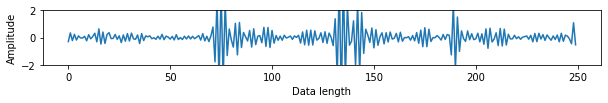

In [25]:
plt.figure(figsize=(10,1))
plt.ylabel('Amplitude')
plt.xlabel('Data length')
plt.ylim((-2, 2))
plt.plot(X_train[12])
plt.show()

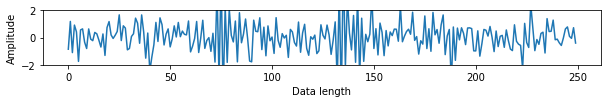

In [26]:
plt.figure(figsize=(10,1))
plt.ylabel('Amplitude')
plt.xlabel('Data length')
plt.ylim((-2, 2))
plt.plot(X_train_noise[12])
plt.show()

In [27]:
y = np.argmax(y_train[12])
y

7

In [28]:
def eca_block(input_feature, b=1, gamma=2, name=""):
    channel = input_feature._keras_shape[-1] # 输入格式(batchsize, stpes, channels)
    kernel_size = int(abs((math.log(channel, 2) + b) / gamma))
    kernel_size = kernel_size if kernel_size % 2 else kernel_size + 1

    # 输入(batch_size, steps, features) (None, 27, 30)  输出(batch_size, features)(None, 30) 
    avg_pool = GlobalAveragePooling1D()(input_feature)
    
    x = Reshape((-1, 1))(avg_pool) #(None, 30, 1)
    # 输入(batch_size, steps, input_dim)(None, 30, 1)      输出(batch_size, new_steps, filters)(None, 30 , 1)
    x = Conv1D(1, kernel_size=kernel_size, padding="same", name = "eca_layer_"+str(name), use_bias=False,)(x)
    x = Activation('sigmoid')(x) # 输出(None, 30, 1)
    x = Reshape((1, -1))(x) # 输出(None, 1, 30)

    output = multiply([input_feature, x])#　(None, 27, 30)(None, 1, 30)
    return output # (None, 27, 30) 

In [29]:
def built_model():  # 特征提取器将1×250输入信号转换为30×27矩阵
    K.clear_session() #清除之前的模型，省得压满内存

    
    input_seq = Input(shape=(250,))  # 每个样本 250  个数据点，现在模型就会以尺寸为 (*, 250) 的数组作为输入
    X = Reshape((250,1))(input_seq)  # 1 维，时间片长度为250的向量（这里隐藏了batchsize）
    
    # encoder1  
    # "channels_last" 对应输入尺寸为 (batch, steps, channels) (Keras 中时序数据的默认格式) ，输出尺寸：batch_size, new_steps, filters
    ec1_layer1 = Conv1D(filters=50, kernel_size=20, strides=2,  # 卷积核的数量就是 out_channels 的数量；核维度默认和输入通道数相同
                       padding='valid', activation='tanh')(X)
    ec1_layer2 = Conv1D(filters=30, kernel_size=10, strides=2,
                      padding='valid', activation='tanh')(ec1_layer1)
    a = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001)(ec1_layer2)
    ec1_outputs = MaxPooling1D(pool_size=2, strides=None, padding='valid')(a)
    
    # encoder2
    ec2_layer1 = Conv1D(filters=50, kernel_size=6, strides=1,
                       padding='valid', activation='tanh')(X)
    ec2_layer2 = Conv1D(filters=40, kernel_size=6, strides=1,
                      padding='valid', activation='tanh')(ec2_layer1)
    ec2_layer3 = MaxPooling1D(pool_size=2, strides=None, padding='valid')(ec2_layer2)
    ec2_layer4 = Conv1D(filters=30, kernel_size=6, strides=1,
                       padding='valid', activation='tanh')(ec2_layer3)
    ec2_layer5 = Conv1D(filters=30, kernel_size=6, strides=2,
                       padding='valid', activation='tanh')(ec2_layer4)
    b = BatchNormalization(axis=1, momentum=0.99, epsilon=0.001)(ec2_layer5)
    ec2_outputs = MaxPooling1D(pool_size=2, strides=None, padding='valid')(b)

    # Feature fusion
    encoder = multiply([ec1_outputs, ec2_outputs])
    # ECA 划分权重
    att2 = eca_block(encoder)

    dc_layer1 = Bidirectional(GRU(30, return_sequences=True))(att2)
    dc_layer2 = Bidirectional(GRU(30))(dc_layer1)
    dc_layer3 = Dropout(0.5)(dc_layer2)
    dc_layer4 = Dense(10, activation='softmax')(dc_layer3)

    model = Model(input_seq, dc_layer4)
    
    return model

In [30]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, normalize=False):
    plt.imshow(cm , cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_mark = np.arange(len(classes))
    plt.xticks(tick_mark, classes, rotation=40)
    plt.yticks(tick_mark, classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        cm = '%.2f'%cm
    thresh = cm.max()/2.0
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment='center',color='black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

In [31]:
import time
begain_time = time.time()

In [32]:
model = built_model()
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 250, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 245, 50)      350         reshape_1[0][0]                  
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 240, 40)      12040       conv1d_3[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [33]:
checkpointer = ModelCheckpoint(filepath="best_weights1.hdf5", 
                               monitor = 'val_acc', verbose=1, save_best_only=True)

In [34]:
history = model.fit(x=X_train_noise, y=y_train, batch_size = 64, epochs=200,
                    callbacks=[checkpointer], validation_data=(X_valid_noise, y_valid), verbose=2, shuffle=True, initial_epoch=0)

Train on 1680 samples, validate on 360 samples
Epoch 1/200
 - 4s - loss: 0.0845 - acc: 0.2006 - val_loss: 0.0752 - val_acc: 0.4389

Epoch 00001: val_acc improved from -inf to 0.43889, saving model to best_weights1.hdf5
Epoch 2/200
 - 1s - loss: 0.0741 - acc: 0.3476 - val_loss: 0.0619 - val_acc: 0.4611

Epoch 00002: val_acc improved from 0.43889 to 0.46111, saving model to best_weights1.hdf5
Epoch 3/200
 - 1s - loss: 0.0635 - acc: 0.4952 - val_loss: 0.0521 - val_acc: 0.5778

Epoch 00003: val_acc improved from 0.46111 to 0.57778, saving model to best_weights1.hdf5
Epoch 4/200
 - 1s - loss: 0.0556 - acc: 0.5589 - val_loss: 0.0473 - val_acc: 0.6500

Epoch 00004: val_acc improved from 0.57778 to 0.65000, saving model to best_weights1.hdf5
Epoch 5/200
 - 1s - loss: 0.0516 - acc: 0.5720 - val_loss: 0.0420 - val_acc: 0.6444

Epoch 00005: val_acc did not improve from 0.65000
Epoch 6/200
 - 1s - loss: 0.0478 - acc: 0.6232 - val_loss: 0.0398 - val_acc: 0.7250

Epoch 00006: val_acc improved from 0


Epoch 00057: val_acc did not improve from 0.89722
Epoch 58/200
 - 1s - loss: 0.0085 - acc: 0.9464 - val_loss: 0.0205 - val_acc: 0.8722

Epoch 00058: val_acc did not improve from 0.89722
Epoch 59/200
 - 1s - loss: 0.0049 - acc: 0.9714 - val_loss: 0.0195 - val_acc: 0.8833

Epoch 00059: val_acc did not improve from 0.89722
Epoch 60/200
 - 1s - loss: 0.0029 - acc: 0.9851 - val_loss: 0.0185 - val_acc: 0.8917

Epoch 00060: val_acc did not improve from 0.89722
Epoch 61/200
 - 1s - loss: 0.0030 - acc: 0.9833 - val_loss: 0.0202 - val_acc: 0.8639

Epoch 00061: val_acc did not improve from 0.89722
Epoch 62/200
 - 1s - loss: 0.0022 - acc: 0.9869 - val_loss: 0.0191 - val_acc: 0.8889

Epoch 00062: val_acc did not improve from 0.89722
Epoch 63/200
 - 1s - loss: 0.0019 - acc: 0.9911 - val_loss: 0.0179 - val_acc: 0.8972

Epoch 00063: val_acc did not improve from 0.89722
Epoch 64/200
 - 1s - loss: 0.0024 - acc: 0.9851 - val_loss: 0.0246 - val_acc: 0.8556

Epoch 00064: val_acc did not improve from 0.897


Epoch 00117: val_acc did not improve from 0.89722
Epoch 118/200
 - 1s - loss: 4.3216e-04 - acc: 0.9982 - val_loss: 0.0227 - val_acc: 0.8611

Epoch 00118: val_acc did not improve from 0.89722
Epoch 119/200
 - 1s - loss: 3.9014e-04 - acc: 0.9982 - val_loss: 0.0216 - val_acc: 0.8667

Epoch 00119: val_acc did not improve from 0.89722
Epoch 120/200
 - 1s - loss: 4.2077e-04 - acc: 0.9982 - val_loss: 0.0203 - val_acc: 0.8778

Epoch 00120: val_acc did not improve from 0.89722
Epoch 121/200
 - 1s - loss: 3.6422e-04 - acc: 0.9982 - val_loss: 0.0206 - val_acc: 0.8806

Epoch 00121: val_acc did not improve from 0.89722
Epoch 122/200
 - 1s - loss: 3.4784e-04 - acc: 0.9982 - val_loss: 0.0202 - val_acc: 0.8806

Epoch 00122: val_acc did not improve from 0.89722
Epoch 123/200
 - 1s - loss: 4.0657e-04 - acc: 0.9982 - val_loss: 0.0228 - val_acc: 0.8667

Epoch 00123: val_acc did not improve from 0.89722
Epoch 124/200
 - 1s - loss: 4.2439e-04 - acc: 0.9976 - val_loss: 0.0217 - val_acc: 0.8694

Epoch 00124:

 - 1s - loss: 2.9186e-04 - acc: 0.9982 - val_loss: 0.0190 - val_acc: 0.8972

Epoch 00176: val_acc did not improve from 0.90000
Epoch 177/200
 - 1s - loss: 2.5893e-04 - acc: 0.9988 - val_loss: 0.0197 - val_acc: 0.8972

Epoch 00177: val_acc did not improve from 0.90000
Epoch 178/200
 - 1s - loss: 2.2024e-04 - acc: 0.9988 - val_loss: 0.0215 - val_acc: 0.8833

Epoch 00178: val_acc did not improve from 0.90000
Epoch 179/200
 - 1s - loss: 0.0018 - acc: 0.9893 - val_loss: 0.0243 - val_acc: 0.8694

Epoch 00179: val_acc did not improve from 0.90000
Epoch 180/200
 - 1s - loss: 0.0035 - acc: 0.9768 - val_loss: 0.0320 - val_acc: 0.8194

Epoch 00180: val_acc did not improve from 0.90000
Epoch 181/200
 - 1s - loss: 0.0045 - acc: 0.9738 - val_loss: 0.0238 - val_acc: 0.8667

Epoch 00181: val_acc did not improve from 0.90000
Epoch 182/200
 - 1s - loss: 0.0074 - acc: 0.9524 - val_loss: 0.0227 - val_acc: 0.8750

Epoch 00182: val_acc did not improve from 0.90000
Epoch 183/200
 - 1s - loss: 0.0059 - acc: 0

In [35]:
end_time = time.time()
time = end_time - begain_time
print('time:', time)

time: 299.9632685184479


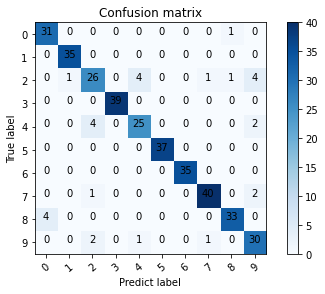

In [36]:
#plt.figure(figsize=(12,9))
y_pre = model.predict(X_test_noise)
label_pre = np.argmax(y_pre, axis=1)
label_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(label_true, label_pre)
plot_confusion_matrix(confusion_mat, classes=range(10))
# plt.savefig('Confusion matrix.jpg')

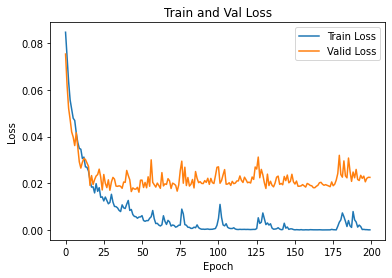

In [37]:
#迭代Loss图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(200)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
# plt.savefig('Train and Val Loss.jpg')
plt.show()

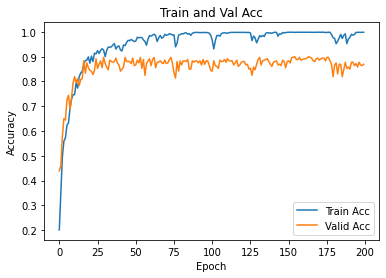

In [38]:
#迭代Acc图像
loss = history.history['acc']
val_loss = history.history['val_acc']
epochs_range = range(200)
plt.plot(epochs_range, loss, label='Train Acc')
plt.plot(epochs_range, val_loss, label='Valid Acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.title('Train and Val Acc')
# plt.savefig('Train and Val Acc.jpg')
plt.show()

In [39]:
# 最终训练的模型
loss, accuracy = model.evaluate(x=X_test_noise, y=y_test, verbose=2)
print("测试集上的损失：", loss)
print("模型上的正确率:", accuracy)

测试集上的损失： 0.014072788258393606
模型上的正确率: 0.9194444444444444
